### Random forest
#### for both standardized and unstandardized, try k-fold

In [5]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix,plot_roc_curve, roc_curve, precision_score,roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

df = pd.read_csv('climate_frog1520_7vars.csv')
X = df[['aet_mean','pet_mean', 'ppt_mean', 'srad_mean', 'tmax_mean', 'tmin_mean','vap_mean']]
y = df['occurrenceStatus']

In [4]:
# do a train test split to reserve some data for testing. This k-fold will NOT use standardize
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
clf = RandomForestClassifier(max_depth = 3, min_samples_leaf = 10, random_state = 0, max_samples = 1000).fit(X_train,y_train)
cv_results = cross_validate(clf, X_train, y_train, cv=4, scoring = ['f1','accuracy','precision','roc_auc'])

In [7]:
cv_results

{'fit_time': array([0.22429967, 0.21959114, 0.29289103, 0.21295309]),
 'score_time': array([0.06813884, 0.08223844, 0.06772113, 0.06595612]),
 'test_f1': array([0.78753454, 0.79001883, 0.79762648, 0.7928125 ]),
 'test_accuracy': array([0.75595133, 0.76406278, 0.77146888, 0.7661788 ]),
 'test_precision': array([0.69948187, 0.71404255, 0.717819  , 0.71384356]),
 'test_roc_auc': array([0.85484584, 0.8586312 , 0.86104628, 0.85283553])}

In [9]:
y_pred = clf.predict(X_validation)
print('f1: ', f1_score(y_validation, y_pred),'accuracy: ',accuracy_score(y_validation, y_pred) )

f1:  0.7884155098133078 accuracy:  0.7626633255772328


In [14]:
# the results look nice. Let's see if standardizing X_train will do any better in k-fold and validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.33, random_state=42)
scaler =StandardScaler().fit(X_train)
X_std = scaler.transform(X_train)

clf = RandomForestClassifier(max_depth = 3, min_samples_leaf = 10, random_state = 0, max_samples = 1000).fit(X_train,y_train)
cv_results = cross_validate(clf, X_std, y_train, cv=4, scoring = ['f1','accuracy','precision','roc_auc'])
cv_results

{'fit_time': array([0.21972036, 0.26332188, 0.217242  , 0.21162963]),
 'score_time': array([0.08047676, 0.06514668, 0.06529331, 0.06751585]),
 'test_f1': array([0.78753454, 0.79001883, 0.79762648, 0.7923173 ]),
 'test_accuracy': array([0.75595133, 0.76406278, 0.77146888, 0.76547346]),
 'test_precision': array([0.69948187, 0.71404255, 0.717819  , 0.71304103]),
 'test_roc_auc': array([0.85505579, 0.8581149 , 0.8609709 , 0.85288397])}

#### There is no major difference between the two results, so we will not use standardscaler. Now let's do a gridsearch on params


In [15]:
params = {'max_depth':[2,5,10,20], 'min_samples_leaf': [10,15,25,30],'max_samples':[500,1000,1500],
         'n_estimators':[50,100,200],'criterion':['gini','entropy']}
scorings = ["roc_auc", 'f1',"precision"]
clf = GridSearchCV(estimator = RandomForestClassifier(random_state = 0), param_grid = params, 
                   cv = 4, scoring = scorings, refit = 'roc_auc', verbose = 3)
clf.fit(X_train,y_train)
print("The Best Model is : ", clf.best_estimator_)

Fitting 4 folds for each of 288 candidates, totalling 1152 fits
[CV 1/4] END criterion=gini, max_depth=2, max_samples=500, min_samples_leaf=10, n_estimators=50; f1: (test=0.789) precision: (test=0.687) roc_auc: (test=0.851) total time=   0.1s
[CV 2/4] END criterion=gini, max_depth=2, max_samples=500, min_samples_leaf=10, n_estimators=50; f1: (test=0.791) precision: (test=0.697) roc_auc: (test=0.853) total time=   0.1s
[CV 3/4] END criterion=gini, max_depth=2, max_samples=500, min_samples_leaf=10, n_estimators=50; f1: (test=0.794) precision: (test=0.710) roc_auc: (test=0.858) total time=   0.1s
[CV 4/4] END criterion=gini, max_depth=2, max_samples=500, min_samples_leaf=10, n_estimators=50; f1: (test=0.794) precision: (test=0.699) roc_auc: (test=0.848) total time=   0.1s
[CV 1/4] END criterion=gini, max_depth=2, max_samples=500, min_samples_leaf=10, n_estimators=100; f1: (test=0.785) precision: (test=0.686) roc_auc: (test=0.850) total time=   0.3s
[CV 2/4] END criterion=gini, max_depth=2

In [16]:
bestForest = RandomForestClassifier(criterion='entropy', max_depth=20, max_samples=1500,
                                    min_samples_leaf=10, random_state=0).fit(X_train,y_train)
y_pred = bestForest.predict(X_validation)
print('f1: ', f1_score(y_validation, y_pred),'accuracy: ',accuracy_score(y_validation, y_pred) )

f1:  0.815366187542779 accuracy:  0.8068730982638267


In [18]:
params = {'n_estimators':[50,100,200],'max_samples':[500,2500,5000]}
scorings = ["roc_auc", 'f1',"precision"]
clf_update = GridSearchCV(estimator = RandomForestClassifier(random_state = 0,criterion='entropy', 
                                                             max_depth=20, min_samples_leaf=10)
                          , param_grid = params, cv = 4, scoring = scorings, refit = 'roc_auc', verbose = 3)
clf_update.fit(X_train,y_train)
print("The Best Model is : ", clf_update.best_estimator_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4] END max_samples=500, n_estimators=50; f1: (test=0.800) precision: (test=0.746) roc_auc: (test=0.872) total time=   0.2s
[CV 2/4] END max_samples=500, n_estimators=50; f1: (test=0.803) precision: (test=0.762) roc_auc: (test=0.878) total time=   0.2s
[CV 3/4] END max_samples=500, n_estimators=50; f1: (test=0.806) precision: (test=0.756) roc_auc: (test=0.879) total time=   0.2s
[CV 4/4] END max_samples=500, n_estimators=50; f1: (test=0.803) precision: (test=0.754) roc_auc: (test=0.873) total time=   0.2s
[CV 1/4] END max_samples=500, n_estimators=100; f1: (test=0.799) precision: (test=0.749) roc_auc: (test=0.871) total time=   0.3s
[CV 2/4] END max_samples=500, n_estimators=100; f1: (test=0.801) precision: (test=0.766) roc_auc: (test=0.878) total time=   0.5s
[CV 3/4] END max_samples=500, n_estimators=100; f1: (test=0.806) precision: (test=0.761) roc_auc: (test=0.880) total time=   0.3s
[CV 4/4] END max_samples=500, n_es

f1:  0.8148084668780529 accuracy:  0.8066046178628961


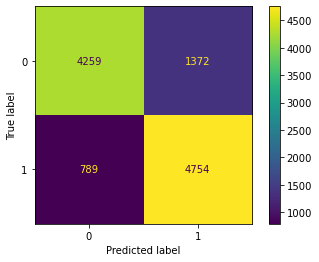

In [26]:
bestForest2 = RandomForestClassifier(criterion='entropy', max_depth=20, max_samples=1500,
                                    min_samples_leaf=10, random_state=0, n_estimators = 200).fit(X_train,y_train)
y_pred = bestForest2.predict(X_validation)
print('f1: ', f1_score(y_validation, y_pred),'accuracy: ',accuracy_score(y_validation, y_pred) )
disp= ConfusionMatrixDisplay(confusion_matrix(y_validation,y_pred))
disp.plot()

f1:  0.8323907455012852 accuracy:  0.8249507785931627


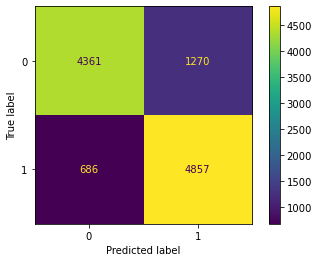

In [27]:
bestForest3 = RandomForestClassifier(criterion='entropy', max_depth=20, max_samples=5000,
                                    min_samples_leaf=10, random_state=0, n_estimators = 200).fit(X_train,y_train)
y_pred = bestForest3.predict(X_validation)
print('f1: ', f1_score(y_validation, y_pred),'accuracy: ',accuracy_score(y_validation, y_pred) )
disp= ConfusionMatrixDisplay(confusion_matrix(y_validation,y_pred))
disp.plot()

In [30]:
# It seems that a larger max_samples will produce a better result. 
# So, keeping everything else the same, do a new GridSearch on max_samples
params = {'n_estimators':[50,100,200],'max_samples':[i * 0.1 for i in range(1, 10)]}
scorings = ["roc_auc", 'f1',"precision"]
clf_new = GridSearchCV(estimator = RandomForestClassifier(random_state = 0,criterion='entropy', 
                                                             max_depth=20, min_samples_leaf=10)
                          , param_grid = params, cv = 4, scoring = scorings, refit = 'f1', verbose = 3)
clf_new.fit(X_train,y_train)
print("The Best Model is : ", clf_new.best_estimator_)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV 1/4] END max_samples=0.1, n_estimators=50; f1: (test=0.822) precision: (test=0.774) roc_auc: (test=0.896) total time=   0.4s
[CV 2/4] END max_samples=0.1, n_estimators=50; f1: (test=0.824) precision: (test=0.784) roc_auc: (test=0.898) total time=   0.2s
[CV 3/4] END max_samples=0.1, n_estimators=50; f1: (test=0.828) precision: (test=0.784) roc_auc: (test=0.902) total time=   0.2s
[CV 4/4] END max_samples=0.1, n_estimators=50; f1: (test=0.825) precision: (test=0.795) roc_auc: (test=0.897) total time=   0.2s
[CV 1/4] END max_samples=0.1, n_estimators=100; f1: (test=0.825) precision: (test=0.778) roc_auc: (test=0.897) total time=   0.5s
[CV 2/4] END max_samples=0.1, n_estimators=100; f1: (test=0.824) precision: (test=0.785) roc_auc: (test=0.898) total time=   0.5s
[CV 3/4] END max_samples=0.1, n_estimators=100; f1: (test=0.829) precision: (test=0.786) roc_auc: (test=0.902) total time=   0.5s
[CV 4/4] END max_samples=0.1, n_

f1:  0.8416795732231975 accuracy:  0.8353320207624844


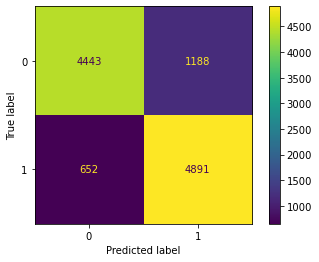

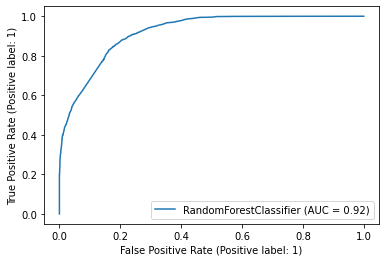

In [41]:
bestForest4 = RandomForestClassifier(criterion='entropy', max_depth=20, max_samples=0.9,
                       min_samples_leaf=10, n_estimators=50, random_state=0).fit(X_train,y_train)
y_pred = bestForest4.predict(X_validation)
print('f1: ', f1_score(y_validation, y_pred),'accuracy: ',accuracy_score(y_validation, y_pred) )
disp= ConfusionMatrixDisplay(confusion_matrix(y_validation,y_pred))
disp.plot()
plot_roc_curve(bestForest4,X_validation,y_validation)

#### Since this current version is overfit, it only generates a submission f1 of 0.61. Now we'll limit the parameters and do a new grid

In [34]:
params = {'max_depth':[4,5,6,8], 'min_samples_leaf': [20,25,30],'max_samples':[500,1000,1500],
         'n_estimators':[100,250,500],'criterion':['gini','entropy']}
scorings = ["roc_auc", 'f1',"precision"]
clf = GridSearchCV(estimator = RandomForestClassifier(random_state = 0), param_grid = params, 
                   cv = 3, scoring = scorings, refit = 'roc_auc', verbose = 3)
clf.fit(X_train,y_train)
print("The Best Model is : ", clf.best_estimator_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 1/3] END criterion=gini, max_depth=4, max_samples=500, min_samples_leaf=20, n_estimators=100; f1: (test=0.782) precision: (test=0.718) roc_auc: (test=0.855) total time=   0.3s
[CV 2/3] END criterion=gini, max_depth=4, max_samples=500, min_samples_leaf=20, n_estimators=100; f1: (test=0.790) precision: (test=0.723) roc_auc: (test=0.865) total time=   0.3s
[CV 3/3] END criterion=gini, max_depth=4, max_samples=500, min_samples_leaf=20, n_estimators=100; f1: (test=0.785) precision: (test=0.723) roc_auc: (test=0.855) total time=   0.3s
[CV 1/3] END criterion=gini, max_depth=4, max_samples=500, min_samples_leaf=20, n_estimators=250; f1: (test=0.781) precision: (test=0.713) roc_auc: (test=0.856) total time=   0.8s
[CV 2/3] END criterion=gini, max_depth=4, max_samples=500, min_samples_leaf=20, n_estimators=250; f1: (test=0.791) precision: (test=0.726) roc_auc: (test=0.866) total time=   0.8s
[CV 3/3] END criterion=gini, max_dept

f1:  0.7904526223357548 accuracy:  0.7650796491856094 precision:  0.7089060710194731


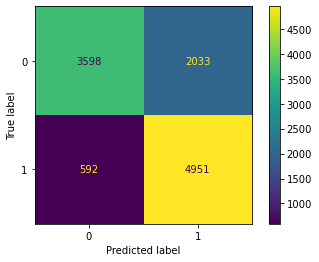

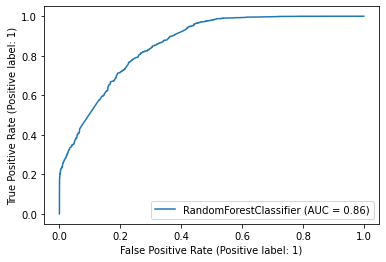

In [42]:
# While running the new grid, we'll try a new submission with what we think as the most "underfit"
bestForest5 = RandomForestClassifier(criterion='entropy', max_depth=4, max_samples=1500,
                       min_samples_leaf=30, n_estimators = 500, random_state=0).fit(X_train,y_train)
y_pred = bestForest5.predict(X_validation)
print('f1: ', f1_score(y_validation, y_pred),'accuracy: ',accuracy_score(y_validation, y_pred), 'precision: ',
      precision_score(y_validation, y_pred))
disp= ConfusionMatrixDisplay(confusion_matrix(y_validation,y_pred))
disp.plot()
plot_roc_curve(bestForest5,X_validation,y_validation)

f1:  0.8031708551189071 accuracy:  0.7911222480758905 precision:  0.7540775930324624


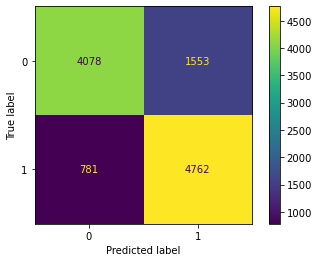

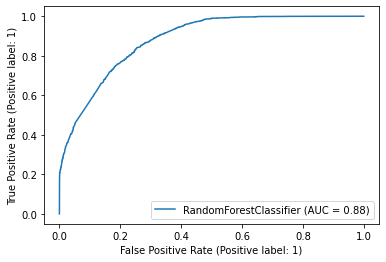

In [43]:
# this is what we get from the new grid, which is still the most overfit the grid can produce
bestForest6 = RandomForestClassifier(criterion='entropy', max_depth=8, max_samples=1500,
                       min_samples_leaf=20, n_estimators=250, random_state=0).fit(X_train,y_train)
y_pred = bestForest6.predict(X_validation)
print('f1: ', f1_score(y_validation, y_pred),'accuracy: ',accuracy_score(y_validation, y_pred), 'precision: ',
      precision_score(y_validation, y_pred))
disp= ConfusionMatrixDisplay(confusion_matrix(y_validation,y_pred))
disp.plot()
plot_roc_curve(bestForest6,X_validation,y_validation)